In [4]:
import os
import time
import pandas as pd
import numpy as np
import math

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Multiply, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adagrad, Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

In [2]:
# Read in the data

anime_data = pd.read_csv('assignment_2_anime.csv')
ratings_train = pd.read_csv('assignment_2_ratings_train.csv')
ratings_test = pd.read_csv('assignment_2_ratings_test.csv')

## Neural network based Collaborative Filtering

### Generalized Matrix Factorization

In [7]:
num_users = len(ratings_train.user_id.unique())
num_anime = len(ratings_train.anime_id.unique())

In [8]:
def get_GMF_model(num_users, num_anime, latent_dim, vu_reg, vi_reg):
    """
    Build Generalized Matrix Factorization Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_anime: int, total number of anime
    latent_dim: int, embedded dimension for user vector and anime vector
    vu_reg: float, L2 regularization of user embedded layer
    vi_reg: float, L2 regularization of anime embedded layer

    Return
    ------
    A Keras Model with GMF model architeture
    """
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    anime_input = Input(shape=(1,), dtype='int32', name='anime_input')

    MF_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(vu_reg),
        input_length=1)
    MF_Embedding_Anime = Embedding(
        input_dim=num_anime + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='anime_embedding',
        embeddings_regularizer=l2(vi_reg),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    anime_latent = Flatten()(MF_Embedding_Anime(anime_input))

    # Element-wise product of user and anime embeddings 
    predict_vector = Multiply()([user_latent, anime_latent])
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, anime_input], prediction)
    
    return model


def train_model(model, learner, batch_size, epochs, val_split, inputs, outputs):
    """
    define training routine, train models and save best model
    
    Parameters
    ----------
    model: a Keras model
    learner: str, one of ['sgd', 'adam', 'rmsprop', 'adagrad']
    batch_size: num samples per update
    epochs: num iterations
    val_split: split ratio for validation data
    inputs: inputs data
    outputs: outputs data
    """
    # add customized metric
    def mse(y_true, y_pred):
        return K.mean(K.square(y_true - y_pred))
    
    # compile model
    model.compile(optimizer=learner.lower(), loss='mean_squared_error', metrics=['mean_squared_error', mse])
    
    # add call backs
    early_stopper = EarlyStopping(monitor='val_mse', patience=3, verbose=1)
    
    # train model
    history = model.fit(inputs, outputs,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=val_split,
                        callbacks=[early_stopper])
    return history

In [9]:
GMF_model = get_GMF_model(num_users, num_anime, 10, 0, 0)
GMF_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
anime_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        684220      user_input[0][0]                 
__________________________________________________________________________________________________
anime_embedding (Embedding)     (None, 1, 10)        96330       anime_input[0][0]                
______________________________________________________________________________________________

In [10]:
# model config
BATCH_SIZE = 64
EPOCHS = 5
VAL_SPLIT = 0.20

# train model
history = train_model(GMF_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[ratings_train.user_id.values, ratings_train.anime_id.values],
                      outputs=ratings_train.rating.values)

Epoch 1/5
55451/55451 [==============================] - 236s 4ms/step - loss: 5.2396 - mean_squared_error: 5.2396 - mse: 5.2396 - val_loss: 1.9458 - val_mean_squared_error: 1.9458 - val_mse: 1.9458
Epoch 2/5
55451/55451 [==============================] - 236s 4ms/step - loss: 1.8674 - mean_squared_error: 1.8674 - mse: 1.8674 - val_loss: 1.8792 - val_mean_squared_error: 1.8792 - val_mse: 1.8792
Epoch 3/5
55451/55451 [==============================] - 239s 4ms/step - loss: 1.7851 - mean_squared_error: 1.7851 - mse: 1.7851 - val_loss: 1.8618 - val_mean_squared_error: 1.8618 - val_mse: 1.8618
Epoch 4/5
55451/55451 [==============================] - 248s 4ms/step - loss: 1.7373 - mean_squared_error: 1.7373 - mse: 1.7373 - val_loss: 1.8621 - val_mean_squared_error: 1.8621 - val_mse: 1.8621
Epoch 5/5
55451/55451 [==============================] - 238s 4ms/step - loss: 1.7081 - mean_squared_error: 1.7081 - mse: 1.7081 - val_loss: 1.8608 - val_mean_squared_error: 1.8608 - val_mse: 1.8608


In [16]:
def plot_learning_curve(history, metric):
    """
    Plot learning curve to compare training error vs. validation error
    """
    # get training error
    errors = history.history[metric]
    # get validation error
    val_errors = history.history['val_{}'.format(metric)]
    # get epochs
    epochs = range(1, len(errors) + 1)

    # plot
    plt.figure(figsize=(12, 7))
    plt.plot(epochs, errors, 'bo', label='training {}'.format(metric))
    plt.plot(epochs, val_errors, 'b', label='validation {}'.format(metric))
    plt.xlabel('number of epochs')
    plt.ylabel(metric)
    plt.title('Model Learning Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

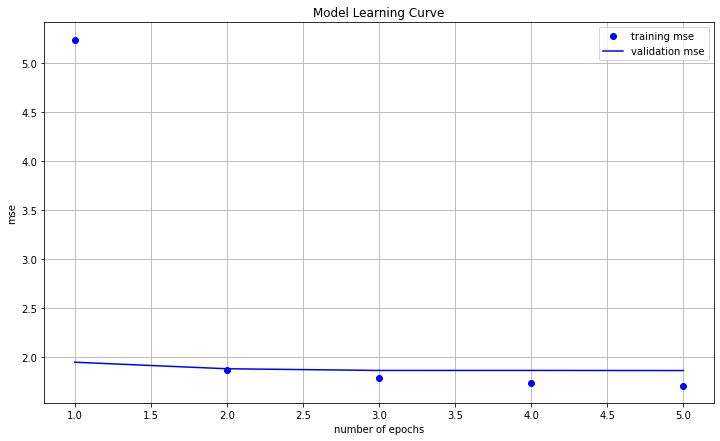

In [17]:
plot_learning_curve(history, 'mse')

In [19]:
mse = lambda true, pred: np.mean(np.square(np.squeeze(predictions) - np.squeeze(ratings_test.rating.values)))

predictions = GMF_model.predict([ratings_test.user_id.values, ratings_test.anime_id.values])

error = mse(ratings_test.rating.values, predictions)
print('Test MSE: ', round(error, 3))

Test MSE:  1.859


In [23]:
def get_MLP_model(num_users, num_anime, layers, reg_layers):
    """
    Build Multi-Layer Perceptron Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_anime: int, total number of anime
    layers: list of int, each element is the number of hidden units for each layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and anime latent vector
    reg_layers: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) # Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    anime_input = Input(shape=(1,), dtype='int32', name='anime_input')

    MLP_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1)
    MLP_Embedding_Anime = Embedding(
        input_dim=num_anime + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='anime_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    anime_latent = Flatten()(MLP_Embedding_Anime(anime_input))

    # The 0-th layer is the concatenation of embedding layers
    vector = Concatenate(axis=-1)([user_latent, anime_latent])

    # MLP layers
    for idx in range(1, num_layer):
        layer = Dense(
            units=layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(reg_layers[idx]),
            name = 'layer%d' %idx)
        vector = layer(vector)
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(vector)
    
    # Stitch input and output
    model = Model([user_input, anime_input], prediction)
    
    return model

In [24]:
MLP_model = get_MLP_model(num_users, num_anime, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
anime_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 32)        2189504     user_input[0][0]                 
__________________________________________________________________________________________________
anime_embedding (Embedding)     (None, 1, 32)        308256      anime_input[0][0]                
____________________________________________________________________________________________

In [25]:
# model config
BATCH_SIZE = 64
EPOCHS = 5
VAL_SPLIT = 0.2

# train model
history = train_model(MLP_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[ratings_train.user_id.values, ratings_train.anime_id.values],
                      outputs=ratings_train.rating.values)

Epoch 1/5
55451/55451 [==============================] - 339s 6ms/step - loss: 1.8495 - mean_squared_error: 1.8495 - mse: 1.8495 - val_loss: 1.6650 - val_mean_squared_error: 1.6650 - val_mse: 1.6650
Epoch 2/5
55451/55451 [==============================] - 348s 6ms/step - loss: 1.6158 - mean_squared_error: 1.6158 - mse: 1.6158 - val_loss: 1.6217 - val_mean_squared_error: 1.6217 - val_mse: 1.6217
Epoch 3/5
55451/55451 [==============================] - 353s 6ms/step - loss: 1.5639 - mean_squared_error: 1.5639 - mse: 1.5639 - val_loss: 1.6163 - val_mean_squared_error: 1.6163 - val_mse: 1.6163
Epoch 4/5
55451/55451 [==============================] - 345s 6ms/step - loss: 1.5229 - mean_squared_error: 1.5229 - mse: 1.5229 - val_loss: 1.5996 - val_mean_squared_error: 1.5996 - val_mse: 1.5996
Epoch 5/5
55451/55451 [==============================] - 327s 6ms/step - loss: 1.4881 - mean_squared_error: 1.4881 - mse: 1.4881 - val_loss: 1.5953 - val_mean_squared_error: 1.5953 - val_mse: 1.5953


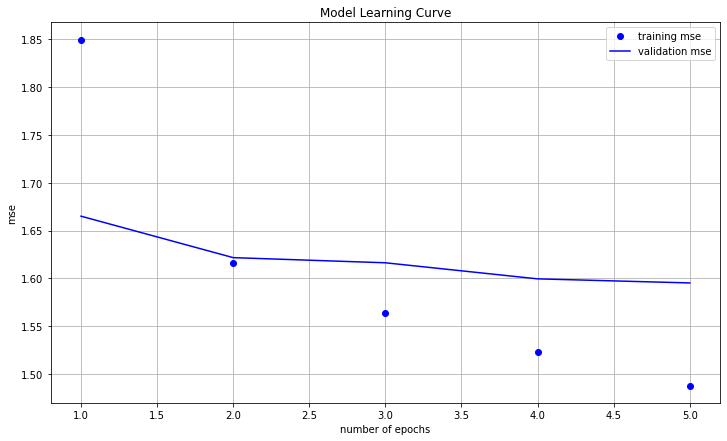

In [26]:
plot_learning_curve(history, 'mse')

In [27]:
# make prediction using test data
predictions = MLP_model.predict([ratings_test.user_id.values, ratings_test.anime_id.values])
# get the MSE
error = mse(ratings_test.rating.values, predictions)
print('Test MSE: ', round(error, 3))

Test MSE:  1.595


In [28]:
def get_NeuMF_model(num_users, num_anime, MF_dim, MF_reg, MLP_layers, MLP_regs):
    """
    Build Neural Matrix Factorization (NeuMF) Model Topology.
    This is stack version of both GMF and MLP
    
    Parameters
    ----------
    num_users: int, total number of users
    num_anime: int, total number of anime
    MF_dim: int, embedded dimension for user vector and anime vector in MF
    MF_reg: tuple of float, L2 regularization of MF embedded layer
    MLP_layers: list of int, each element is the number of hidden units for each MLP layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and anime latent vector
    MLP_regs: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(MLP_layers) == len(MLP_regs)
    num_MLP_layer = len(MLP_layers) # Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    anime_input = Input(shape=(1,), dtype='int32', name='anime_input')

    # Embedding layer
    
    # MF
    MF_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_user_embedding',
        embeddings_regularizer=l2(MF_reg[0]),
        input_length=1)
    MF_Embedding_Anime = Embedding(
        input_dim=num_anime + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_anime_embedding',
        embeddings_regularizer=l2(MF_reg[1]),
        input_length=1)
    
    # MLP
    MLP_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_user_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1)
    MLP_Embedding_Anime = Embedding(
        input_dim=num_anime + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_anime_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1) 
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_anime_latent = Flatten()(MF_Embedding_Anime(anime_input))
    mf_vector = Multiply()([mf_user_latent, mf_anime_latent])

    # MLP part
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_anime_latent = Flatten()(MLP_Embedding_Anime(anime_input))
    mlp_vector = Concatenate(axis=-1)([mlp_user_latent, mlp_anime_latent])
    for idx in range(1, num_MLP_layer):
        layer = Dense(
            units=MLP_layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(MLP_regs[idx]),
            name = 'layer%d' %idx)
        mlp_vector = layer(mlp_vector)
    
    # Concatenate MF and MLP parts
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])

    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, anime_input], prediction)
    
    return model

In [29]:
NeuMF_model = get_NeuMF_model(
    num_users=num_users,
    num_anime=num_anime,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuMF_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
anime_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
mlp_user_embedding (Embedding)  (None, 1, 32)        2189504     user_input[0][0]                 
__________________________________________________________________________________________________
mlp_anime_embedding (Embedding) (None, 1, 32)        308256      anime_input[0][0]                
____________________________________________________________________________________________

In [30]:
# model config
BATCH_SIZE = 64
EPOCHS = 5
VAL_SPLIT = 0.2

# train model
history = train_model(NeuMF_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[ratings_train.user_id.values, ratings_train.anime_id.values],
                      outputs=ratings_train.rating.values)

Epoch 1/5
55451/55451 [==============================] - 364s 7ms/step - loss: 1.8674 - mean_squared_error: 1.8674 - mse: 1.8674 - val_loss: 1.6502 - val_mean_squared_error: 1.6502 - val_mse: 1.6502
Epoch 2/5
55451/55451 [==============================] - 362s 7ms/step - loss: 1.5526 - mean_squared_error: 1.5526 - mse: 1.5526 - val_loss: 1.6085 - val_mean_squared_error: 1.6085 - val_mse: 1.6085
Epoch 3/5
55451/55451 [==============================] - 363s 7ms/step - loss: 1.4659 - mean_squared_error: 1.4659 - mse: 1.4659 - val_loss: 1.6069 - val_mean_squared_error: 1.6069 - val_mse: 1.6069
Epoch 4/5
55451/55451 [==============================] - 366s 7ms/step - loss: 1.4138 - mean_squared_error: 1.4138 - mse: 1.4138 - val_loss: 1.6160 - val_mean_squared_error: 1.6160 - val_mse: 1.6160
Epoch 5/5
55451/55451 [==============================] - 371s 7ms/step - loss: 1.3768 - mean_squared_error: 1.3768 - mse: 1.3768 - val_loss: 1.6152 - val_mean_squared_error: 1.6152 - val_mse: 1.6152


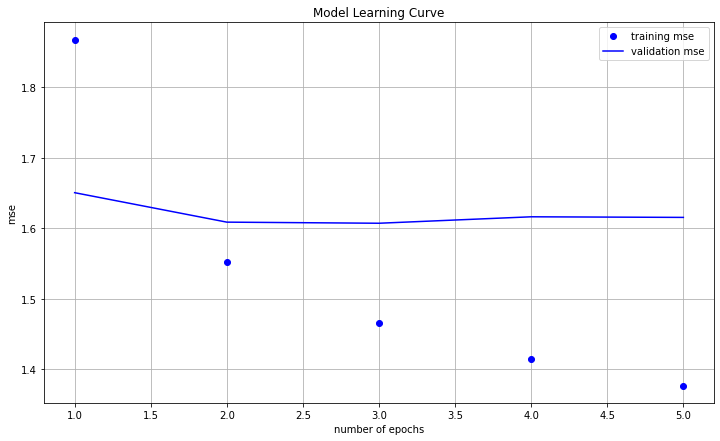

In [31]:
plot_learning_curve(history, 'mse')

In [32]:
# make prediction using test data
predictions = NeuMF_model.predict([ratings_test.user_id.values, ratings_test.anime_id.values])

error = mse(ratings_test.rating.values, predictions)
print('Test MSE: ', round(error, 3))

Test MSE:  1.616
